In [1]:
import os
from datetime import timedelta
import sys

In [2]:
########################### Parameters to adjust ##########################################################################################

destination = None # Available options : 'ifremer',
make_lagrangian_diags = True # True or False

dir_massh = '/bettik/PROJECTS/pr-data-ocean/stellaa/MASSH/mapping'
path_config = './NRT_BFN_main_config.py' 

In [3]:
###########################################################################################################################################
###  0. INITIALIZATION
###########################################################################################################################################

sys.path.append(dir_massh)
currdir=os.getcwd()

from src import exp
config = exp.Exp(path_config)

name_experiment: NRT_BFN_EUREC4A_test
saveoutputs: True
name_exp_save: NRT_BFN_EUREC4A_test
path_save: ./output/20230620/
tmp_DA_path: ./scratch/NRT_BFN_EUREC4A_test
init_date: 2023-06-12 00:00:00
final_date: 2023-06-20 00:00:00
assimilation_time_step: 3:00:00
saveoutput_time_step: 3:00:00
flag_plot: 1
write_obs: False
path_obs: ./scratch/NRT_BFN_EUREC4A_test
name_lon: lon
name_lat: lat
name_time: time
plot_time_step: 1 day, 0:00:00
time_obs_min: None
time_obs_max: None
compute_obs: False

NAME_OBSOP is not set in the configuration file
NAME_BASIS is not set in the configuration file
NAME_DIAG is not set in the configuration file


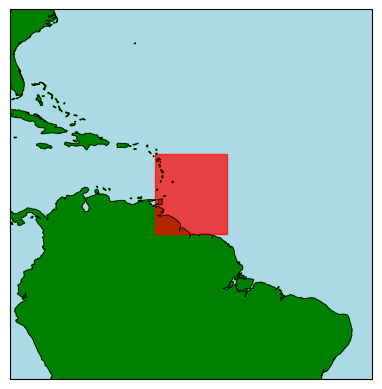

In [4]:
today = config.EXP.final_date
numdays = int((today-config.EXP.init_date)/timedelta(days = 1))

lon_min = config.GRID.lon_min                            
lon_max = config.GRID.lon_max                               
lat_min = config.GRID.lat_min                                 
lat_max = config.GRID.lat_max
bbox = [lon_min, lon_max, lat_min, lat_max]   

from tools.plot_tools import where_is_this
where_is_this(bbox, 20)

In [5]:
###########################################################################################################################################
###  1. DOWNLOAD DATA
###########################################################################################################################################
from tools.ftp_transfer import download_nadirs_cmems, download_swot_nadir


# What datasets to download
datasets = [
    'dataset-duacs-nrt-global-al-phy-l3', 
    'dataset-duacs-nrt-global-c2n-phy-l3', 
    'dataset-duacs-nrt-global-h2b-phy-l3',
    'dataset-duacs-nrt-global-s3a-phy-l3',
    'dataset-duacs-nrt-global-s3b-phy-l3',
    'cmems_obs-sl_glo_phy-ssh_nrt_j3n-l3-duacs_PT1S',
    'cmems_obs-sl_glo_phy-ssh_nrt_s6a-hr-l3-duacs_PT1S',
]

dataset_l4 = 'dataset-duacs-nrt-global-merged-allsat-phy-l4'

# FTP connection to CMEMS server and data download
download_nadirs_cmems(currdir, today, numdays, datasets, dataset_l4)
download_swot_nadir(currdir, today)

Retreiving data for nrt_global_al_phy_l3_20230601_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230602_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230603_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230604_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230605_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230606_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230607_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230608_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230609_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230610_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230611_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230612_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230613_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230614_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230615_20230620.nc
Retreiving data for nrt_global_al_phy_l3_20230616_20230620.nc
Retreivi

In [6]:
from tools.remapping import make_mdt

# If needed, download appropriate mdt file
make_mdt(currdir, bbox, dataset_mdt = 'mdt_hybrid_cnes_cls18_cmems2020_global.nc')

MDT downloaded successfully


In [7]:
############################################################################################################################################
### 2. COMPUTE BOUNDARY CONDITIONS
############################################################################################################################################
from tools.remapping import compute_filled_map

# Rework DUACS dataset for optimal boundary conditions : extrapolate data to fill coasts. 
# Then a mask is used in BFN to select only ocean and avoid awkward 0 values around coasts
BC_data_path = currdir+'/input/'+today.strftime('%Y%m%d')+'/dataset-duacs-nrt-global-merged-allsat-phy-l4/*.nc'
save_new_BC_to = currdir+'/input/'+today.strftime('%Y%m%d')+'/duacs_l4_filled.nc'

compute_filled_map(BC_data_path, save_new_BC_to, bbox)

In [8]:
############################################################################################################################################
### 3. RUN DATA ASSIMILATION WITH BFN-QG
############################################################################################################################################

# State
from src import state as state
State = state.State(config)

super: GRID_GEO
lon_min: -62.0
lon_max: -52.0
lat_min: 6.0
lat_max: 17.0
dlon: 0.125
dlat: 0.125
name_init_mask: ./input/20230620/duacs_l4_filled.nc
name_var_mask: {'lon': 'longitude', 'lat': 'latitude', 'var': 'adt'}



In [9]:
# Obs
from src import obs as obs # if no files to open, re-download data
dict_obs = obs.Obs(config,State)

Observation information will be saved in dict_obs_ALG_C2N_H2B_J3N_S3A_S3B_S6A_SWOTN_20230612_20230620_-62_-52_6_17_10800.txt

ALG:
super: OBS_SSH_NADIR
path: ./input/20230620/dataset-duacs-nrt-global-al-phy-l3/
name_time: time
name_lon: longitude
name_lat: latitude
name_var: {'SSH': 'sla_unfiltered'}
varmax: 100.0
sigma_noise: None
add_mdt: True
substract_mdt: None
path_mdt: ./input/cnes_mdt_local.nc
name_var_mdt: {'lon': 'longitude', 'lat': 'latitude', 'mdt': 'mdt'}
nudging_params_ssh: {'sigma': 0, 'K': 0.7, 'Tau': datetime.timedelta(days=1)}

--> 9 tracks selected

C2N:
super: OBS_SSH_NADIR
path: ./input/20230620/dataset-duacs-nrt-global-c2n-phy-l3/
name_time: time
name_lon: longitude
name_lat: latitude
name_var: {'SSH': 'sla_unfiltered'}
varmax: 100.0
sigma_noise: None
add_mdt: True
substract_mdt: None
path_mdt: ./input/cnes_mdt_local.nc
name_var_mdt: {'lon': 'longitude', 'lat': 'latitude', 'mdt': 'mdt'}
nudging_params_ssh: {'sigma': 0, 'K': 0.7, 'Tau': datetime.timedelta(days=1)}



In [10]:
# Model
from src import mod as mod
Model = mod.Model(config,State)

super: MOD_QG1L_NP
name_var: {'SSH': 'ssh', 'PV': 'pv'}
init_from_bc: False
dist_sponge_bc: 30
name_init_var: {}
dir_model: None
var_to_save: None
dtmodel: 600
upwind: 3
upwind_adj: None
Reynolds: False
qgiter: 20
qgiter_adj: None
c0: 2.2
filec_aux: None
name_var_c: {'lon': '', 'lat': '', 'var': ''}
cmin: None
cmax: None
only_diffusion: False
path_mdt: None
name_var_mdt: {'lon': '', 'lat': '', 'mdt': '', 'mdu': '', 'mdv': ''}
g: 9.81



In [11]:
# Bondary Conditions
from src import bc as bc
Bc = bc.Bc(config)

super: BC_EXT
file: ./input/20230620/duacs_l4_filled.nc
name_lon: longitude
name_lat: latitude
name_time: time
name_var: {'SSH': 'adt_full'}



super: INV_BFN
window_size: 7 days, 0:00:00
window_output: 3 days, 0:00:00
propagation_timestep: 3:00:00
window_overlap: True
criterion: 0.001
max_iteration: 10
save_trajectory: False
dist_scale: 10
save_obs_proj: False
path_save_proj: None
use_bc_as_init: False
scalenudg: None



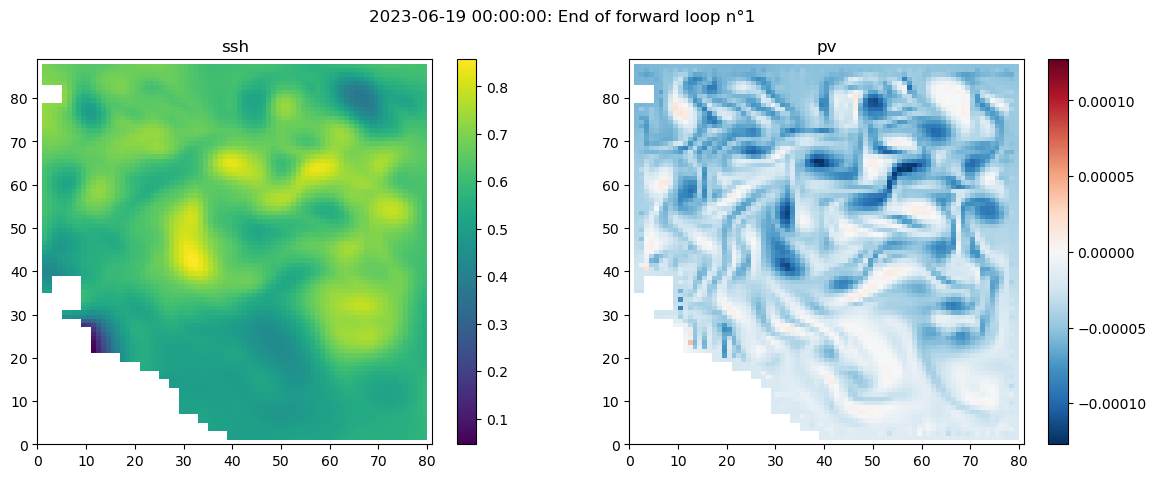

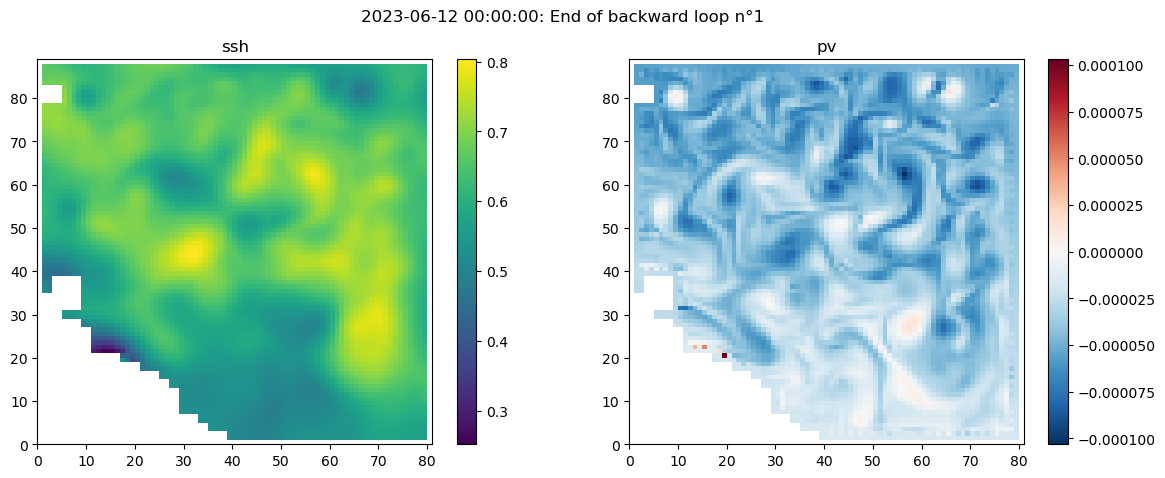

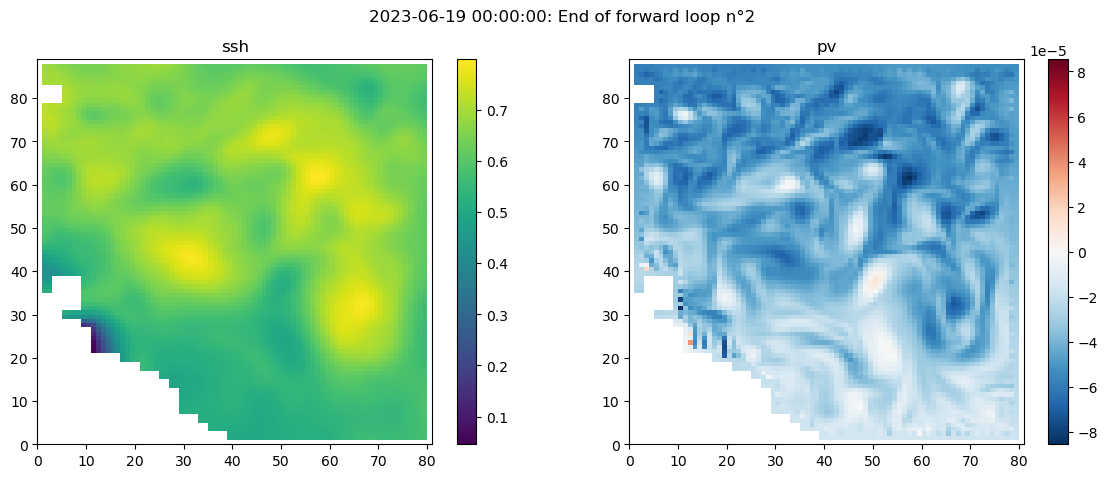

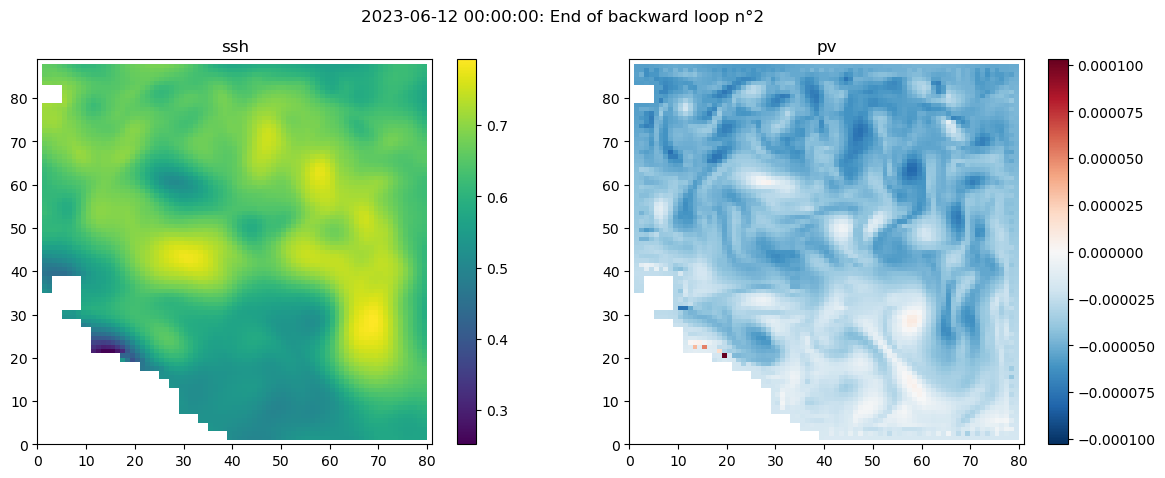

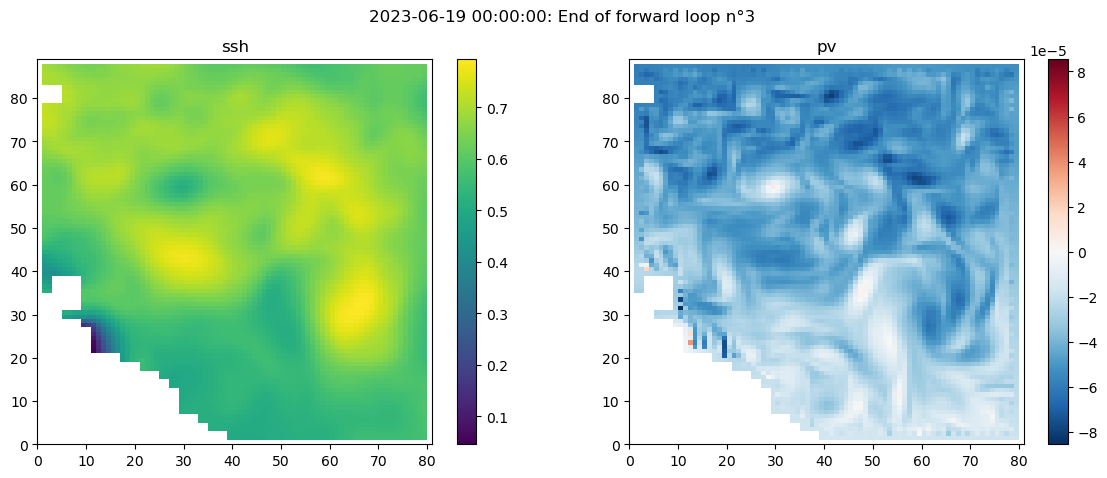

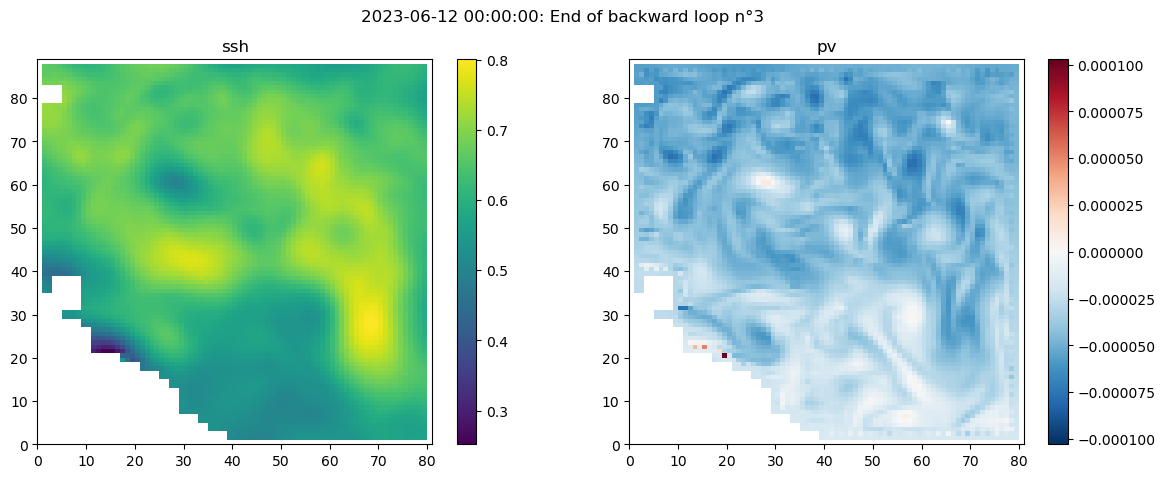

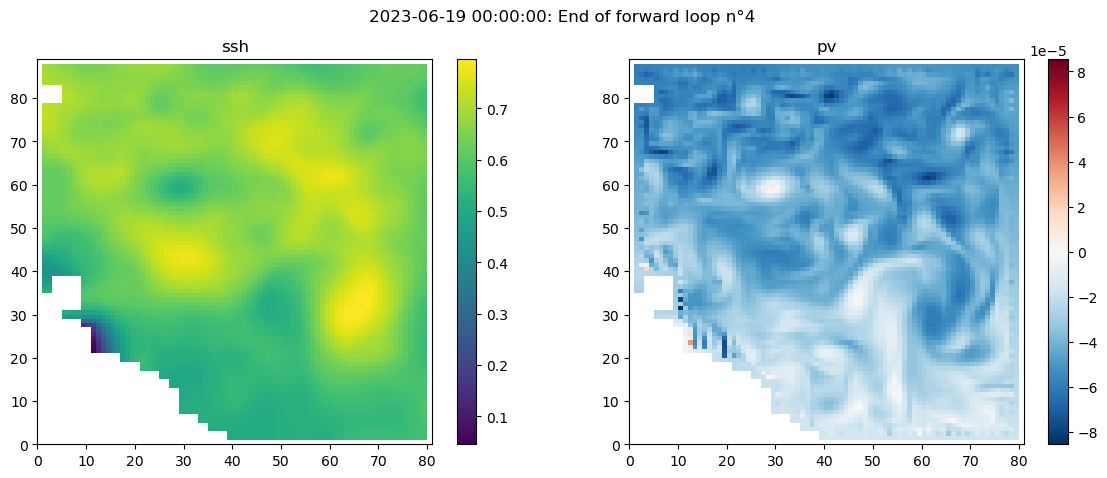

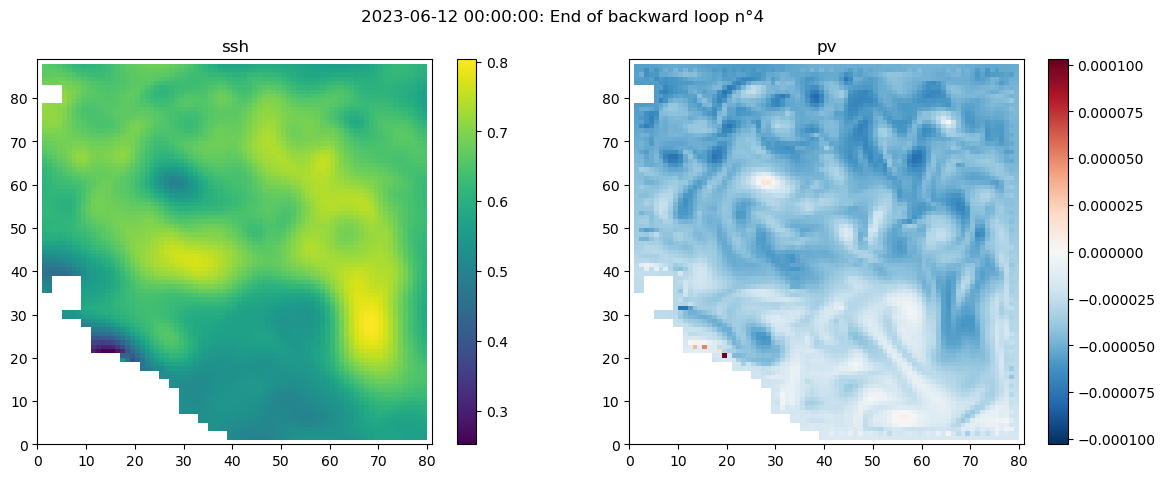

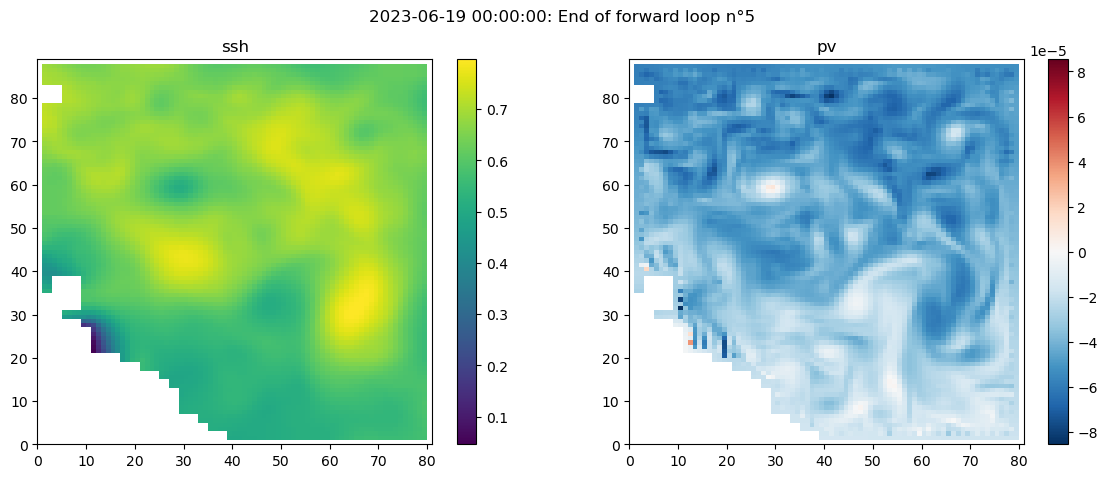

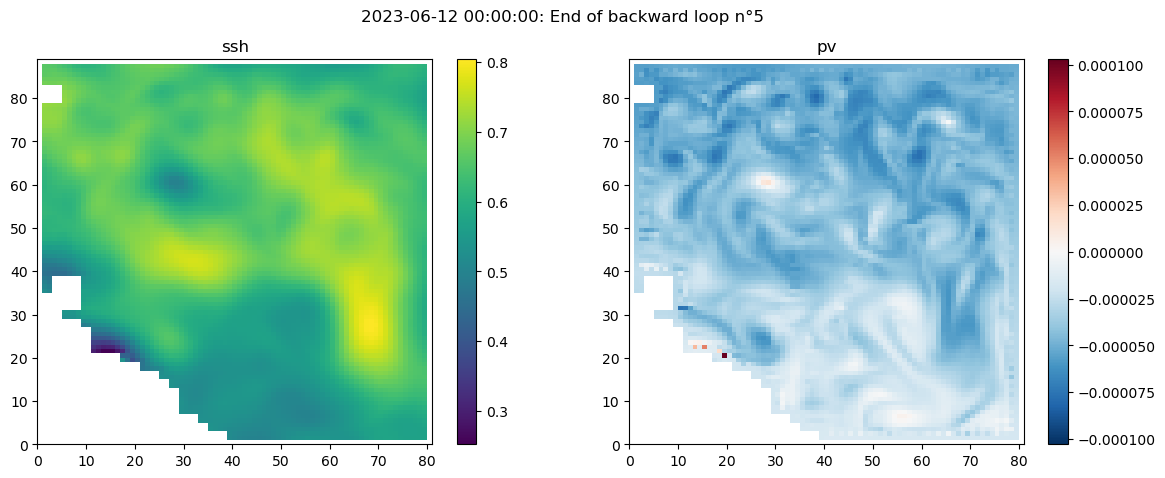

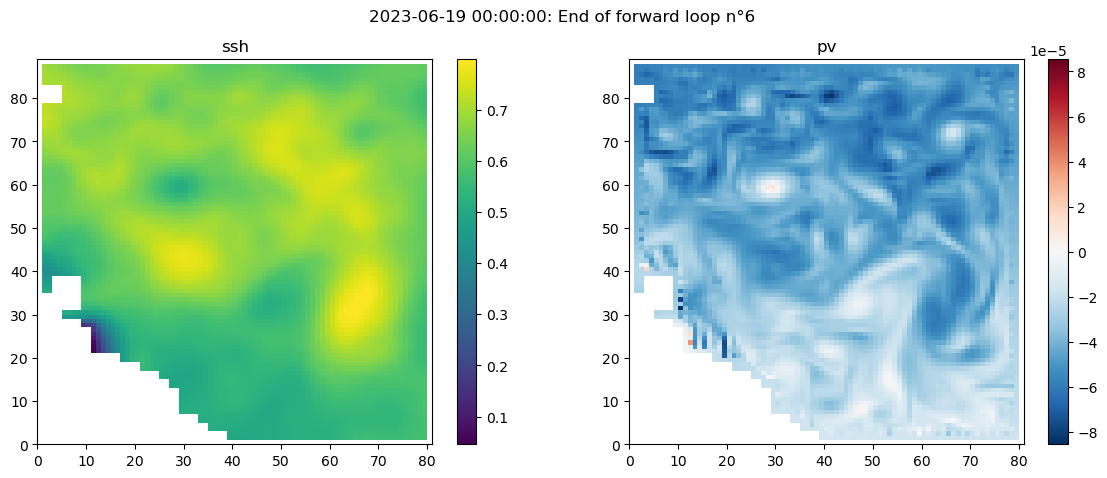

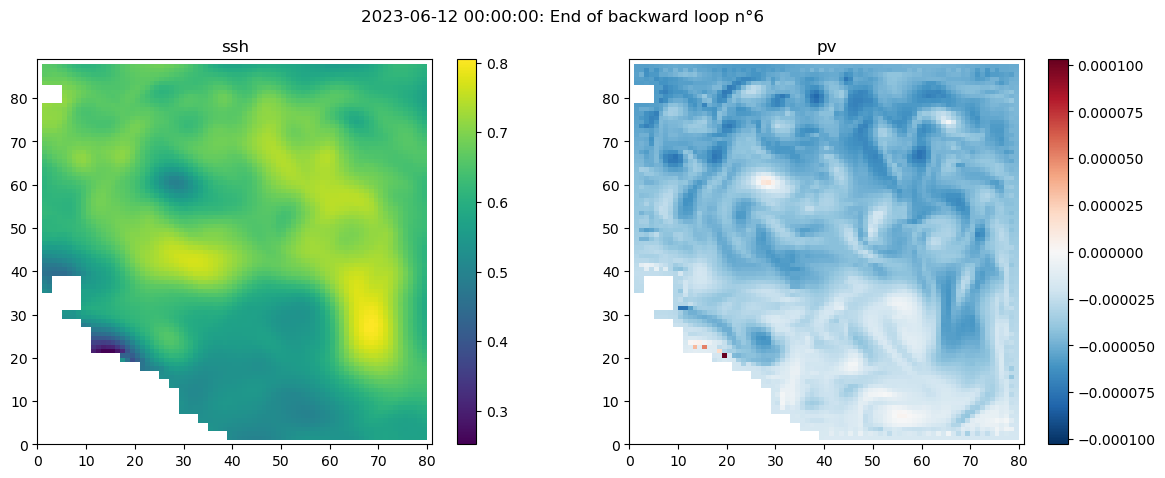

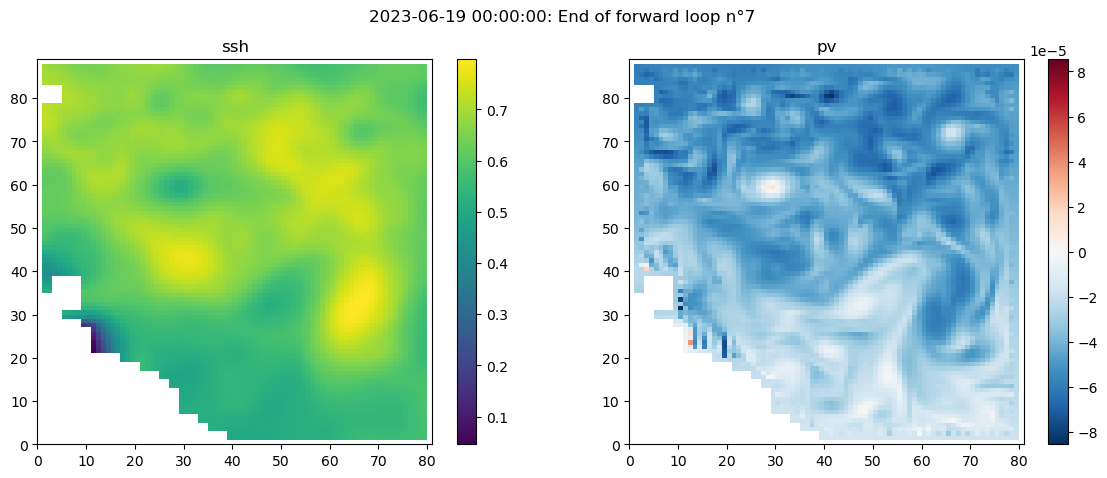

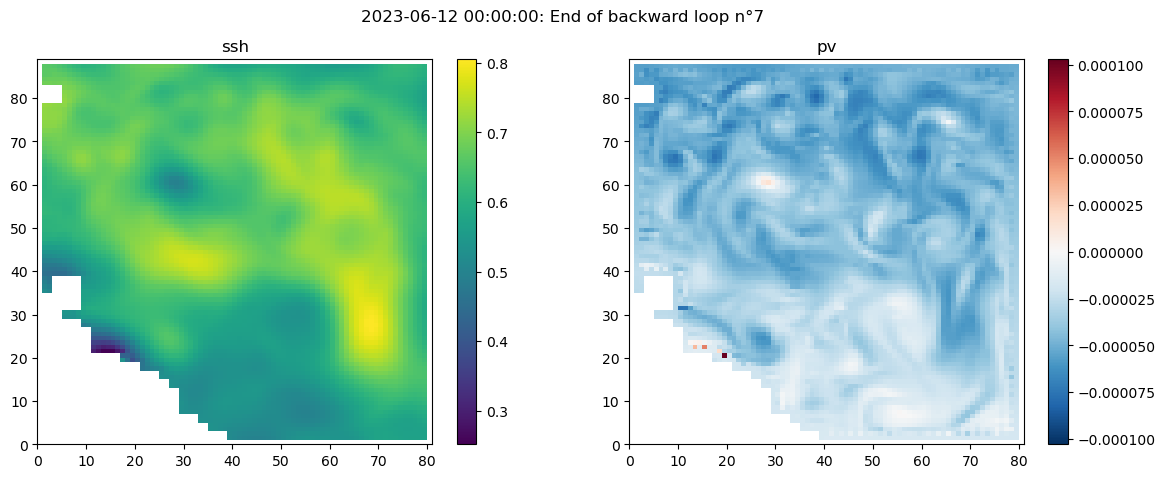

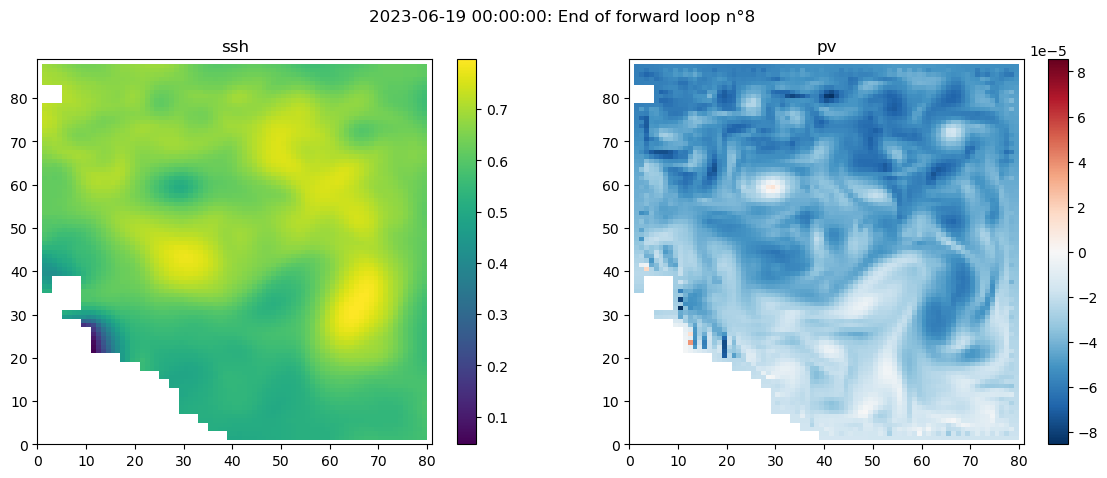

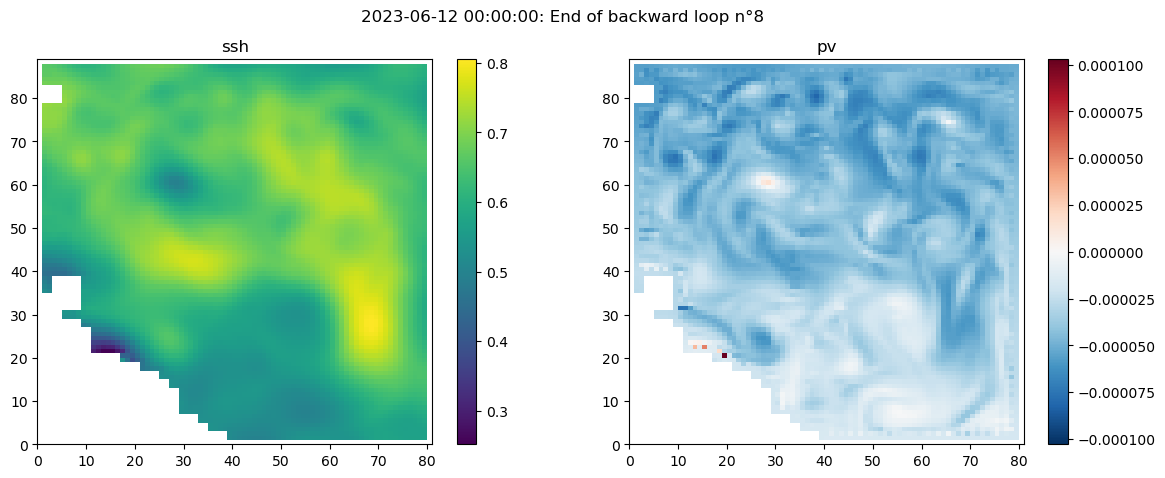

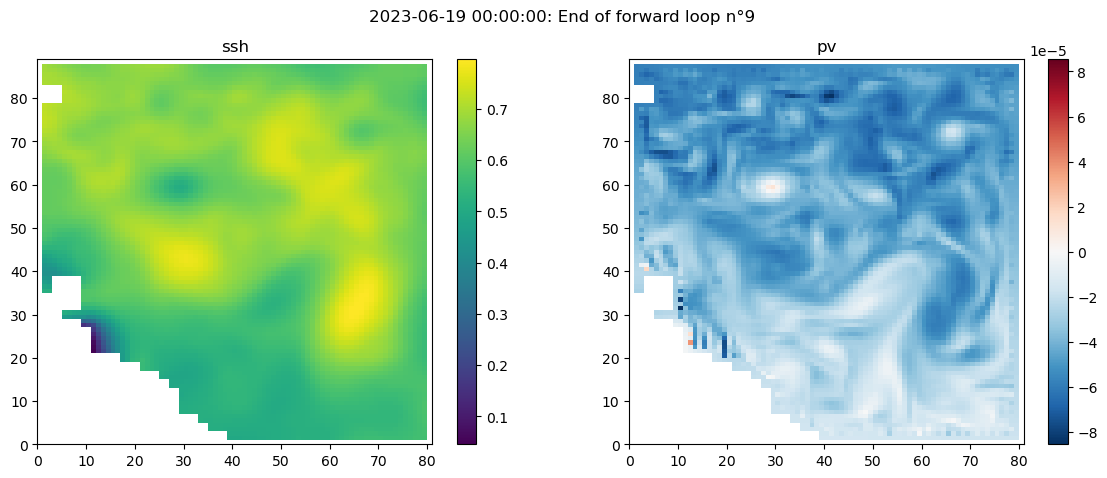

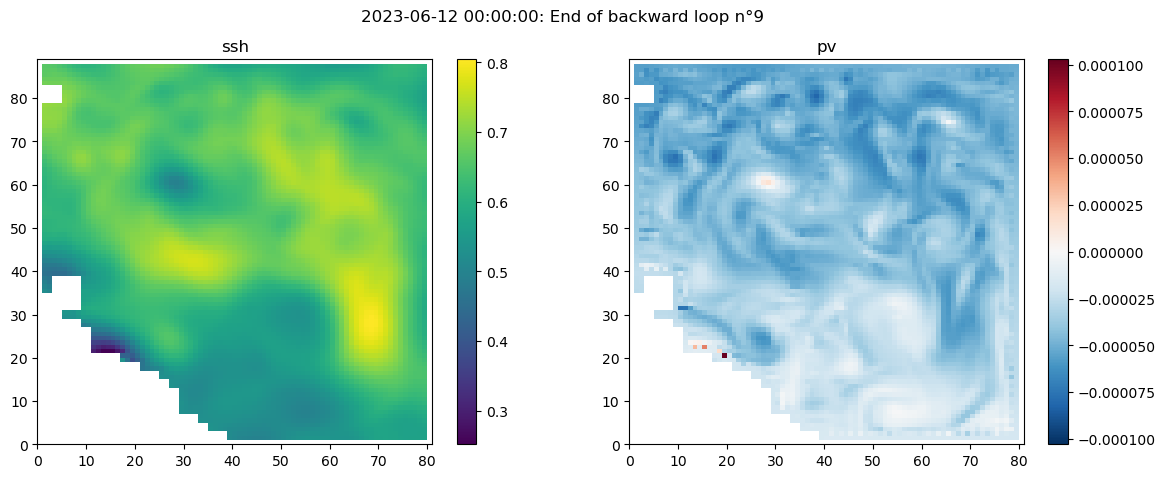

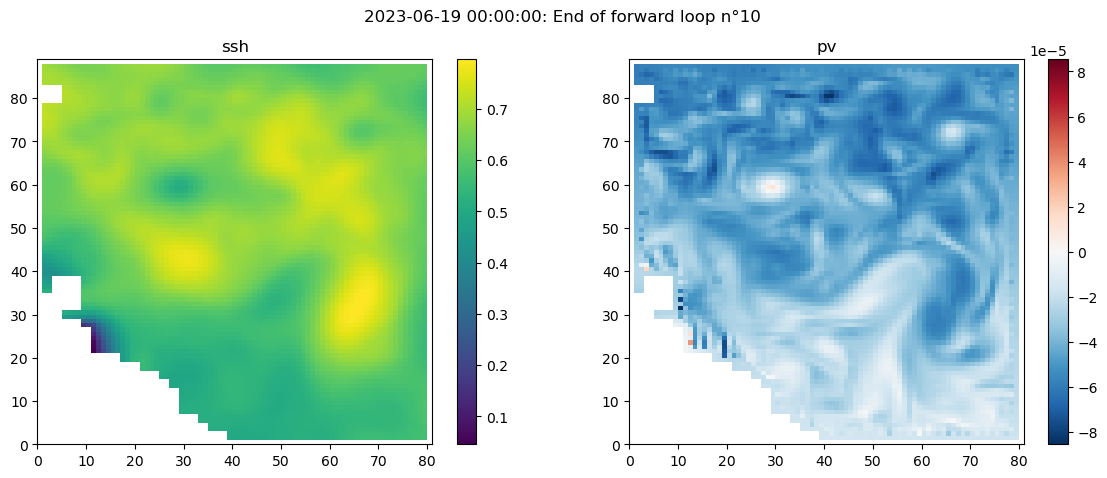

Loop from 2023-06-12 to 2023-06-19 : 10 iterations in 0:04:47.447676 seconds


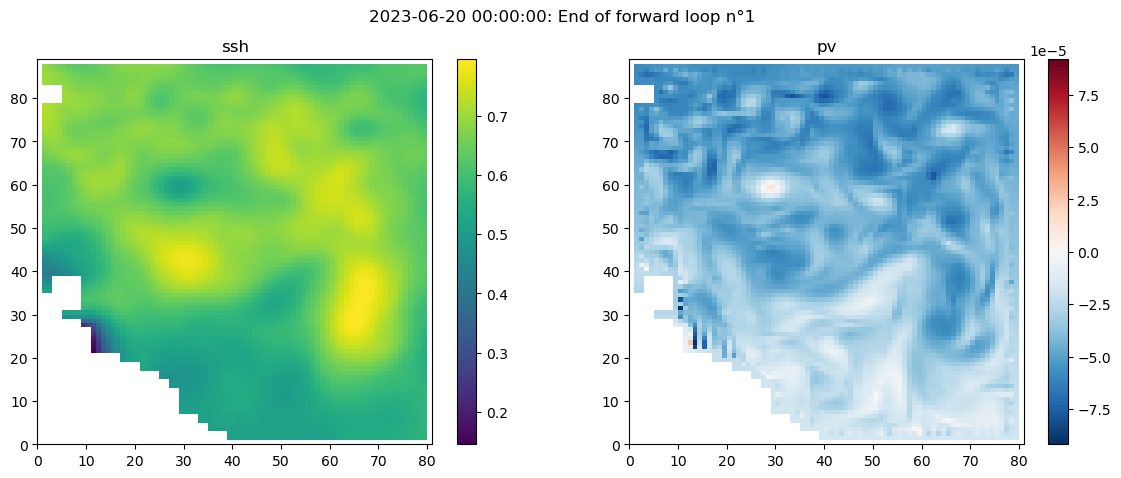

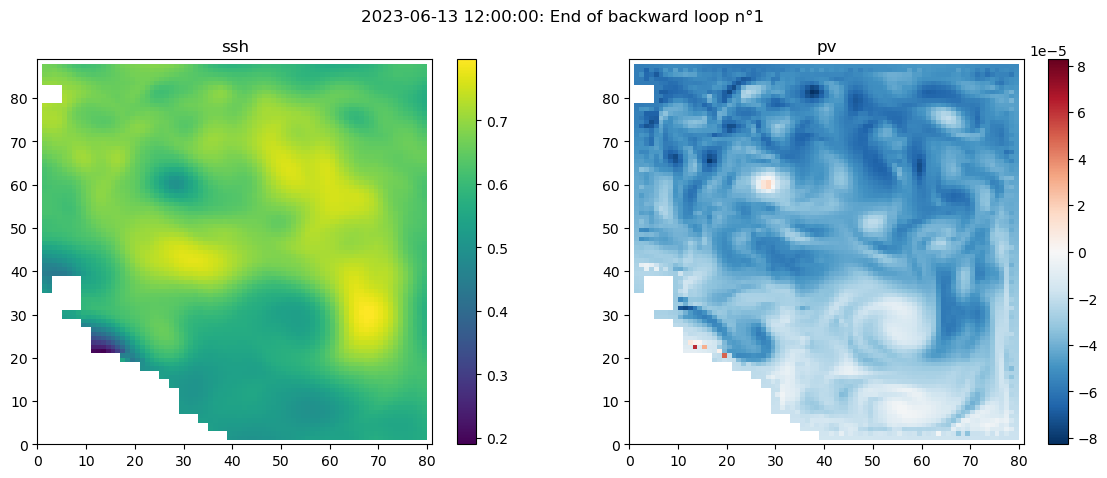

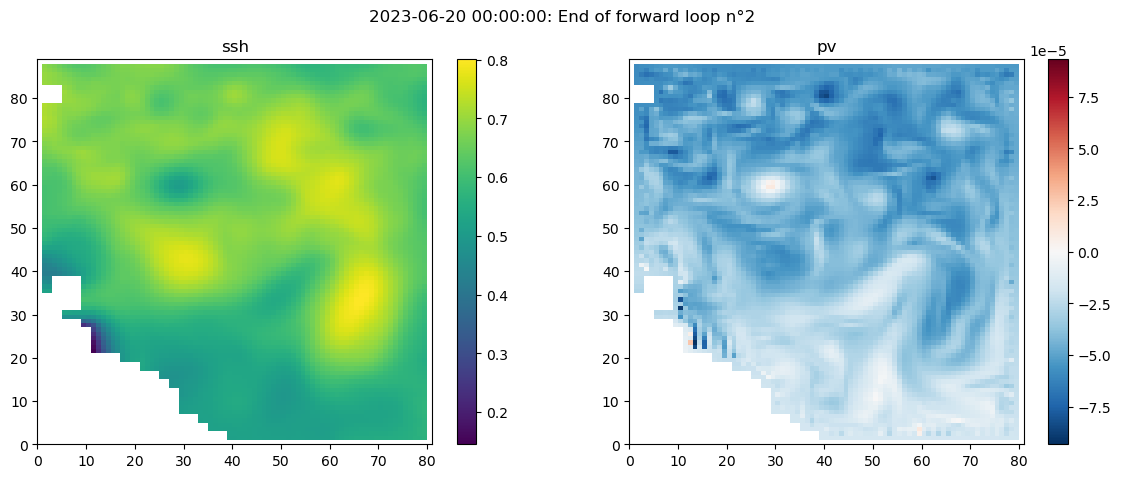

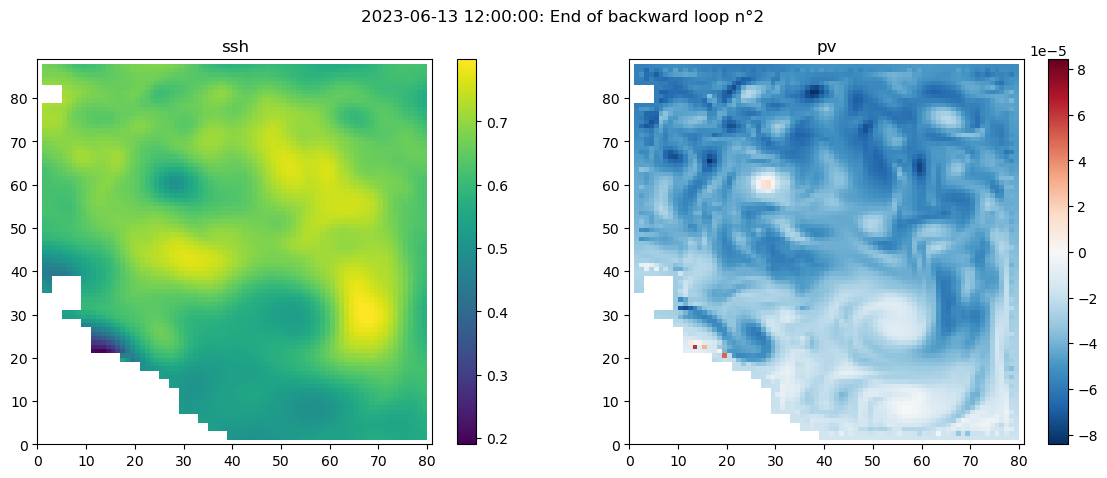

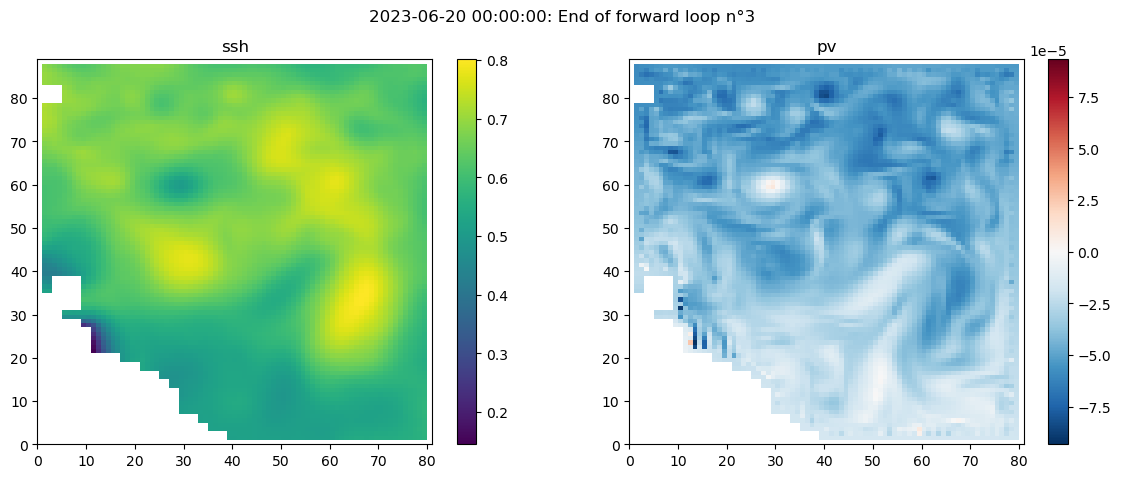

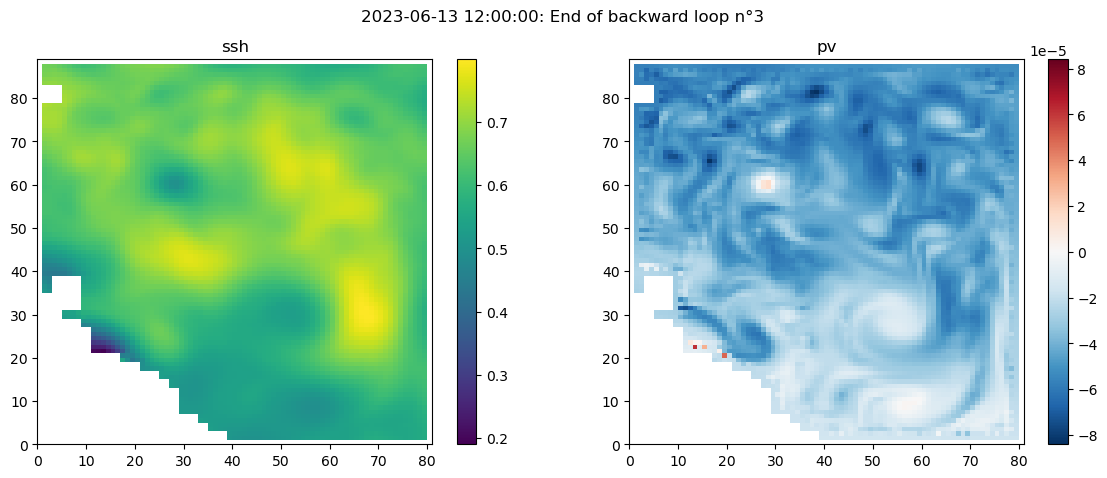

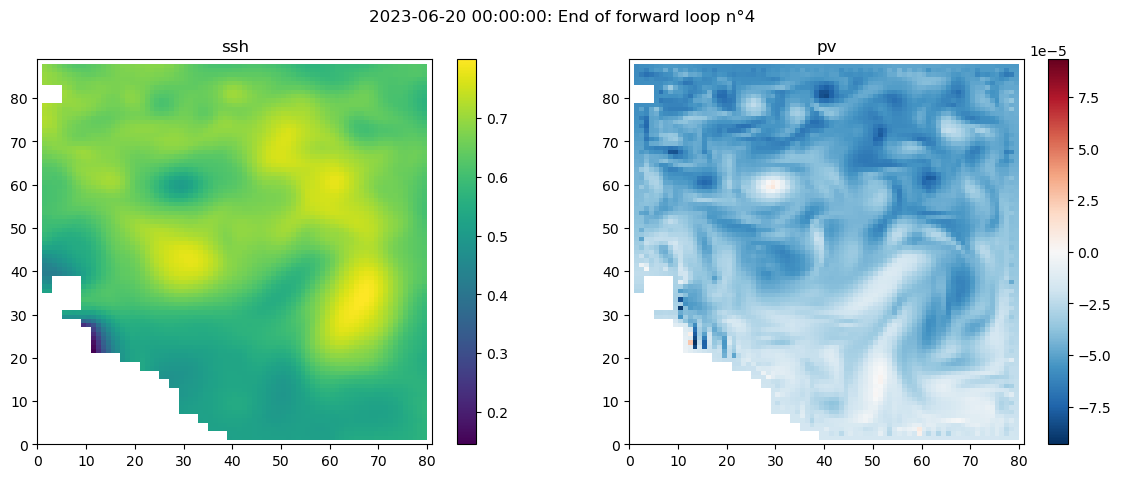

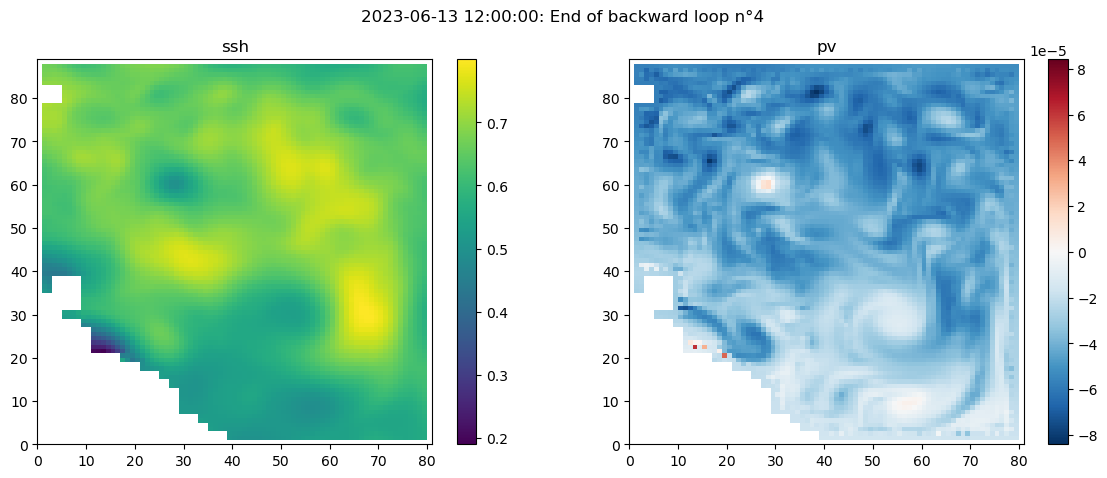

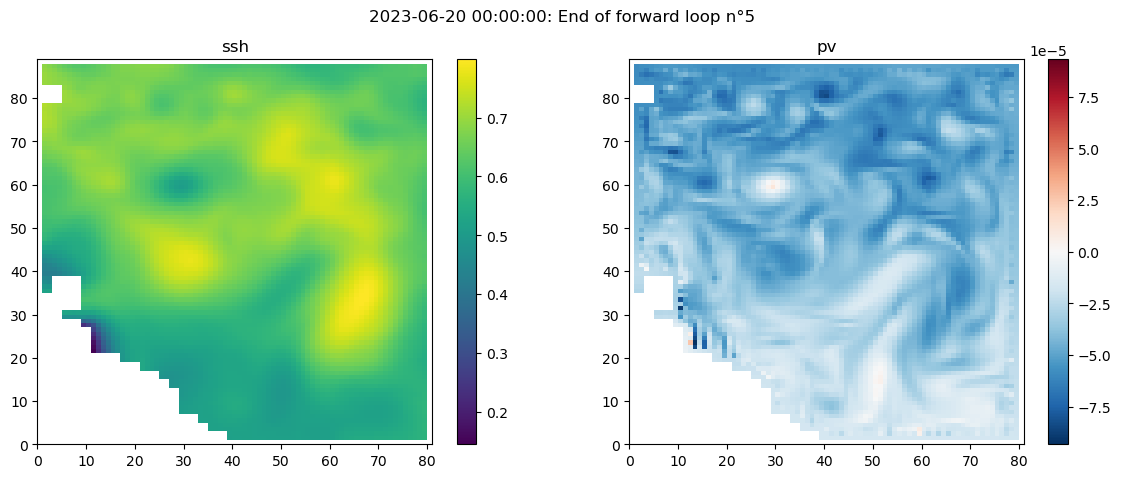

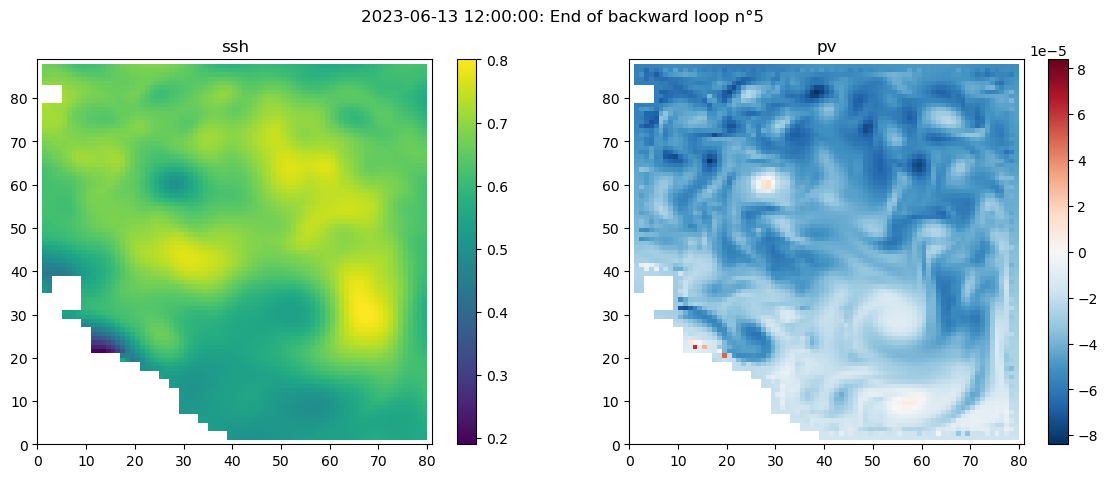

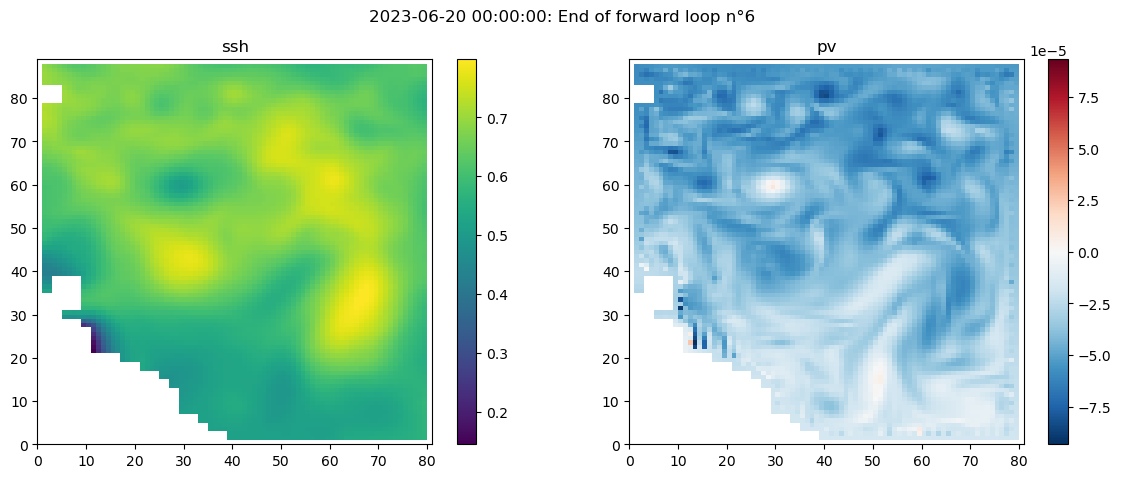

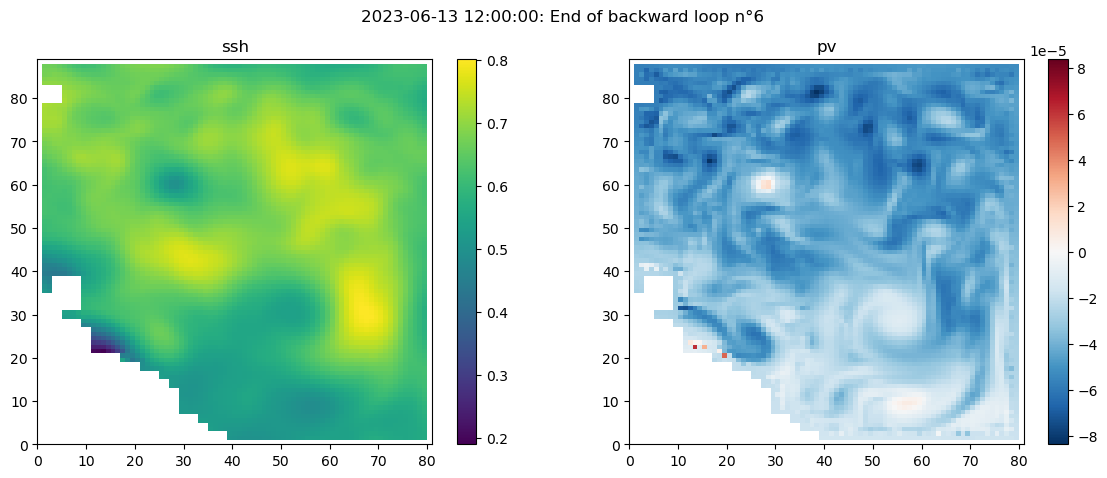

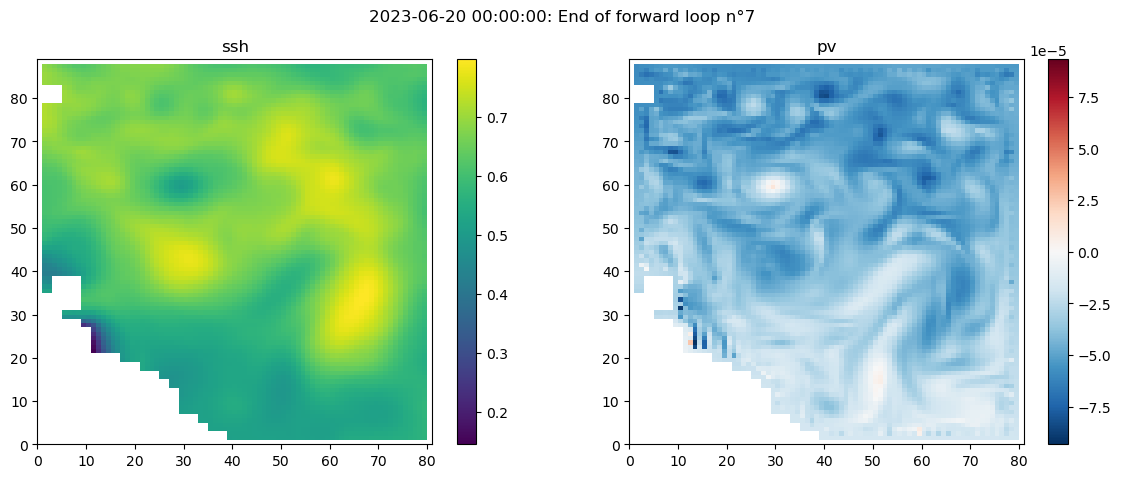

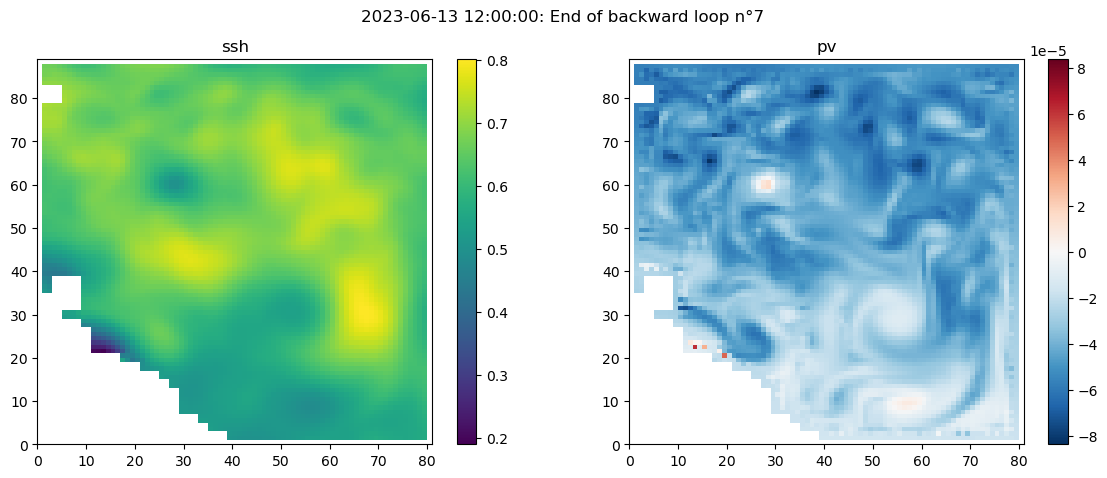

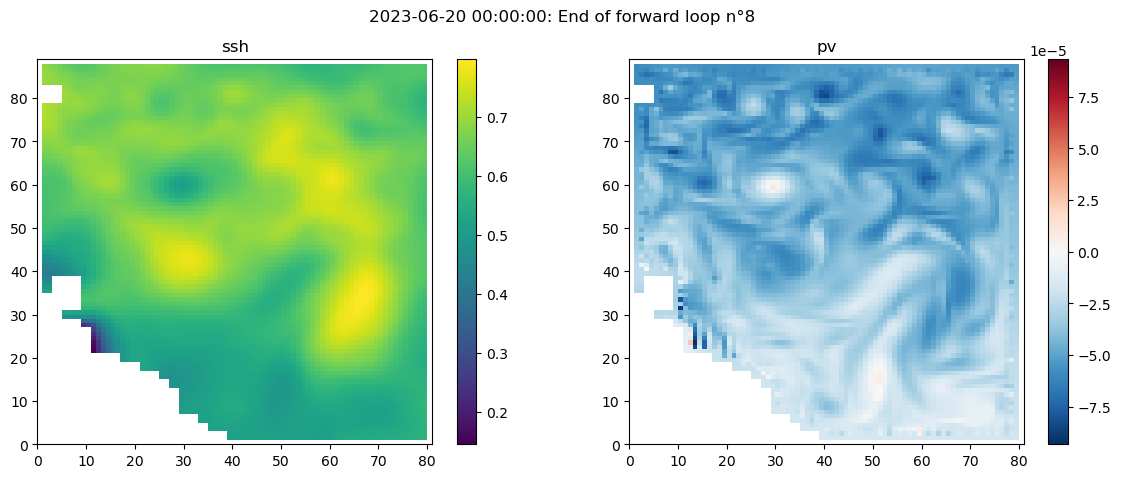

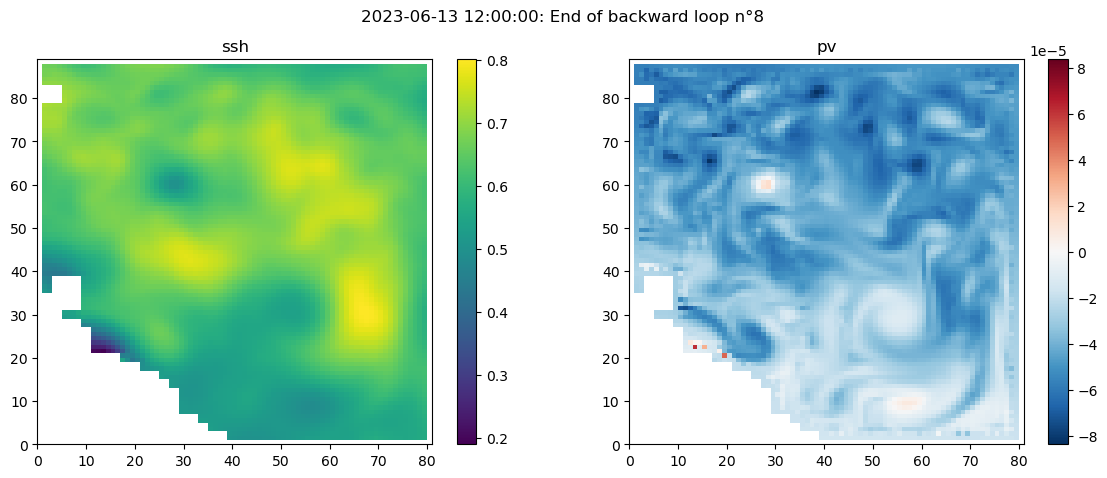

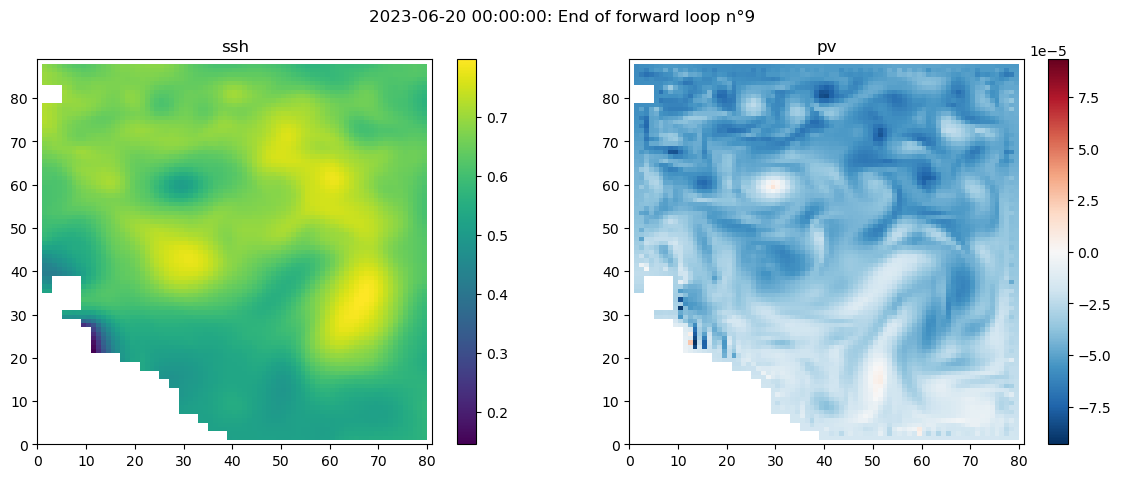

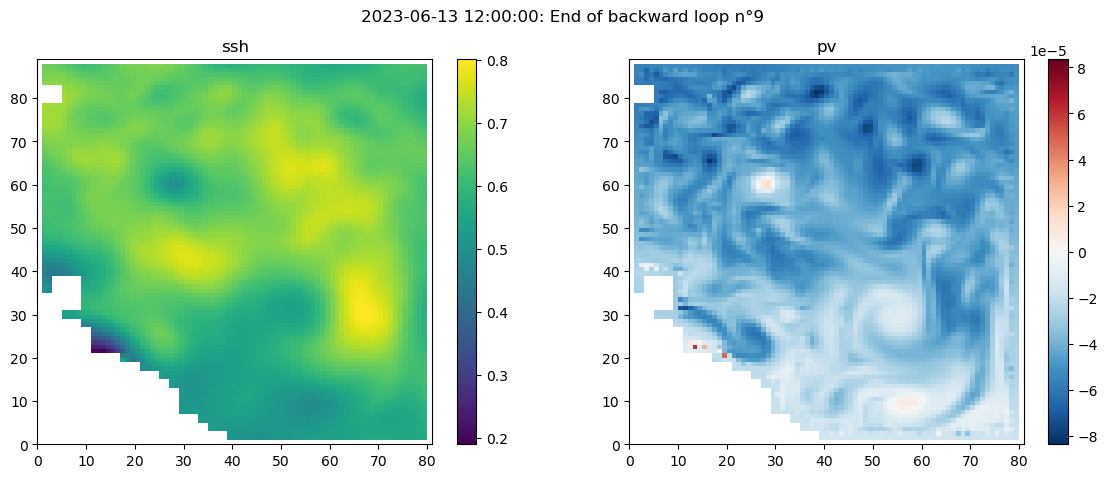

Loop from 2023-06-13 to 2023-06-20 : 9 iterations in 0:04:04.036198 seconds



In [12]:
# Inversion
from src import inv as inv
inv.Inv(config,State,Model,dict_obs=dict_obs,Bc=Bc)

In [14]:
###########################################################################################################################################
### 4. PROCESS RESULTS
###########################################################################################################################################
from tools.remapping import nc_processing
nc_processing(today=today)

/bettik/PROJECTS/pr-data-ocean/stellaa/lamtaLR/Diagnostics.py:449: RuntimeWarning: All-NaN slice encountered
  maxv = np.nanmax(tmp)


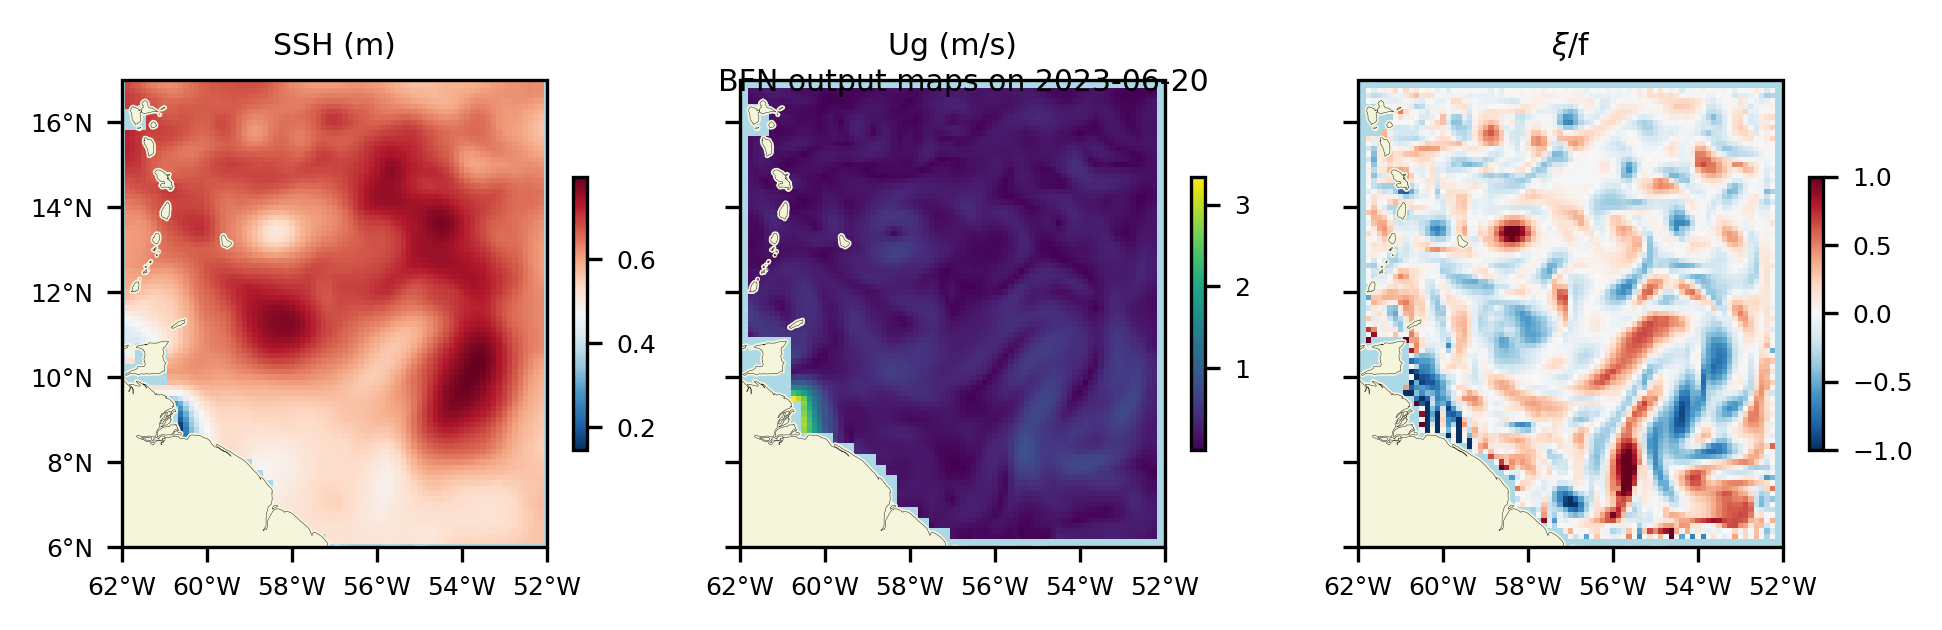

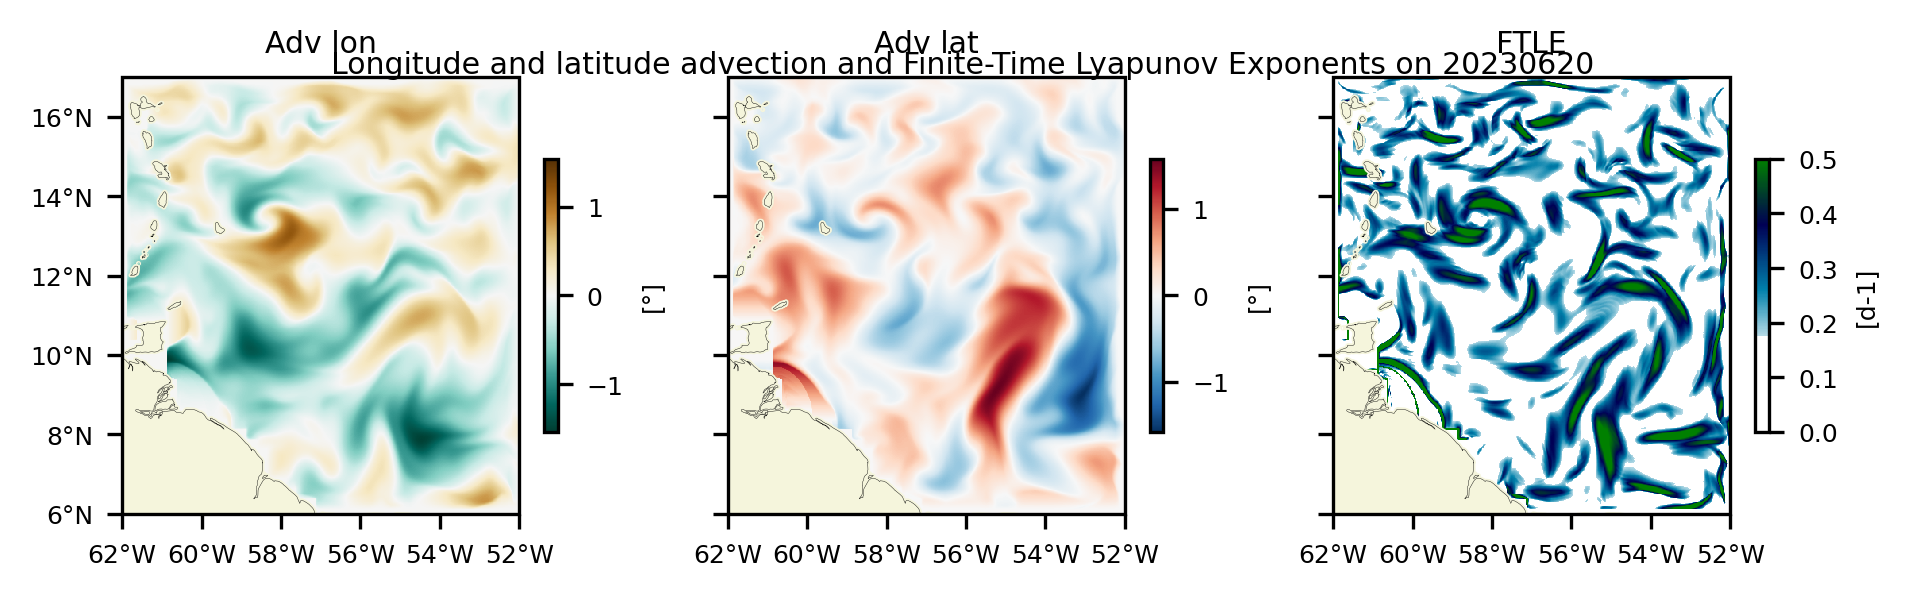

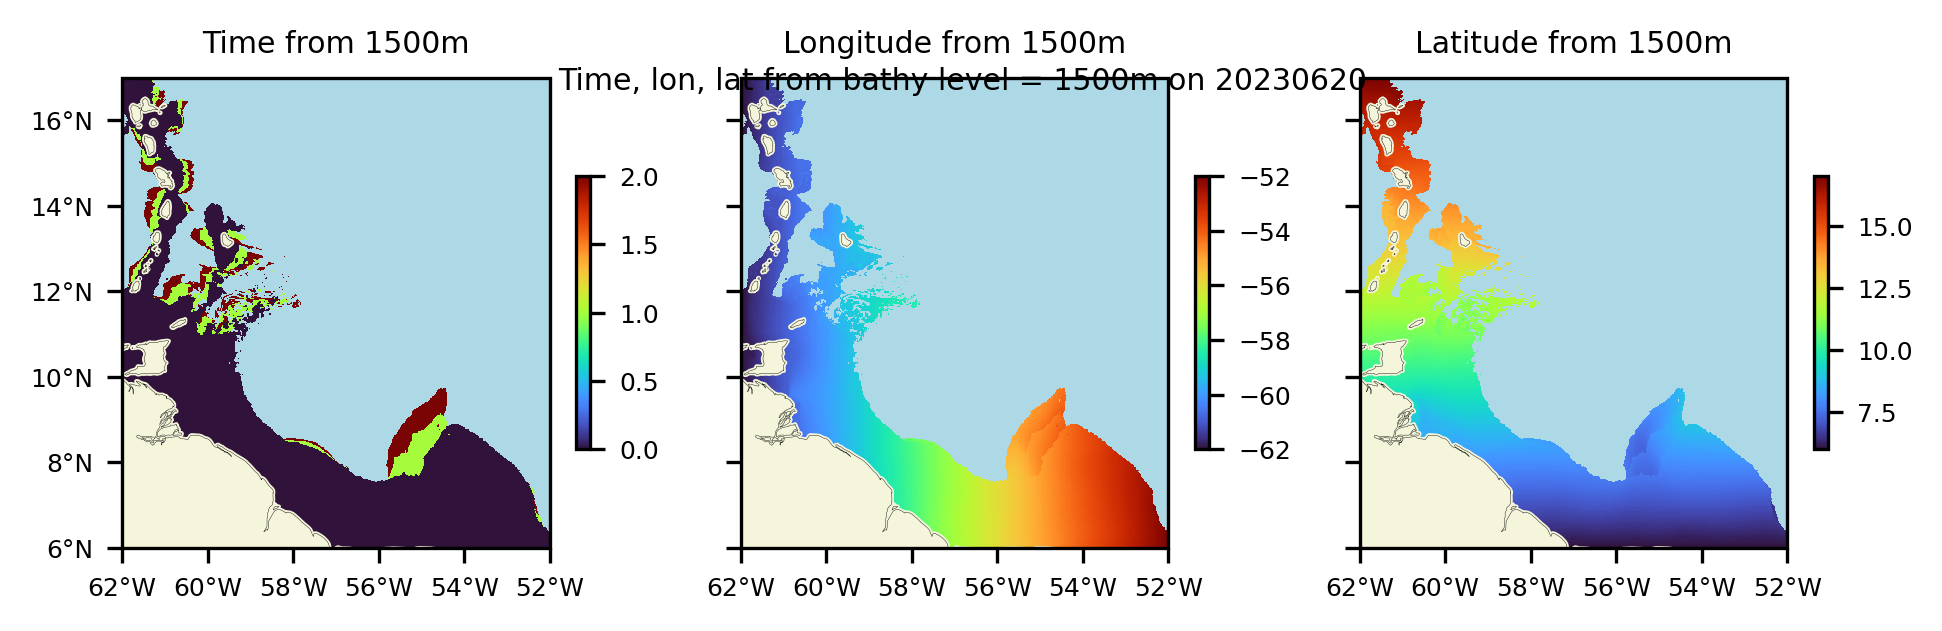

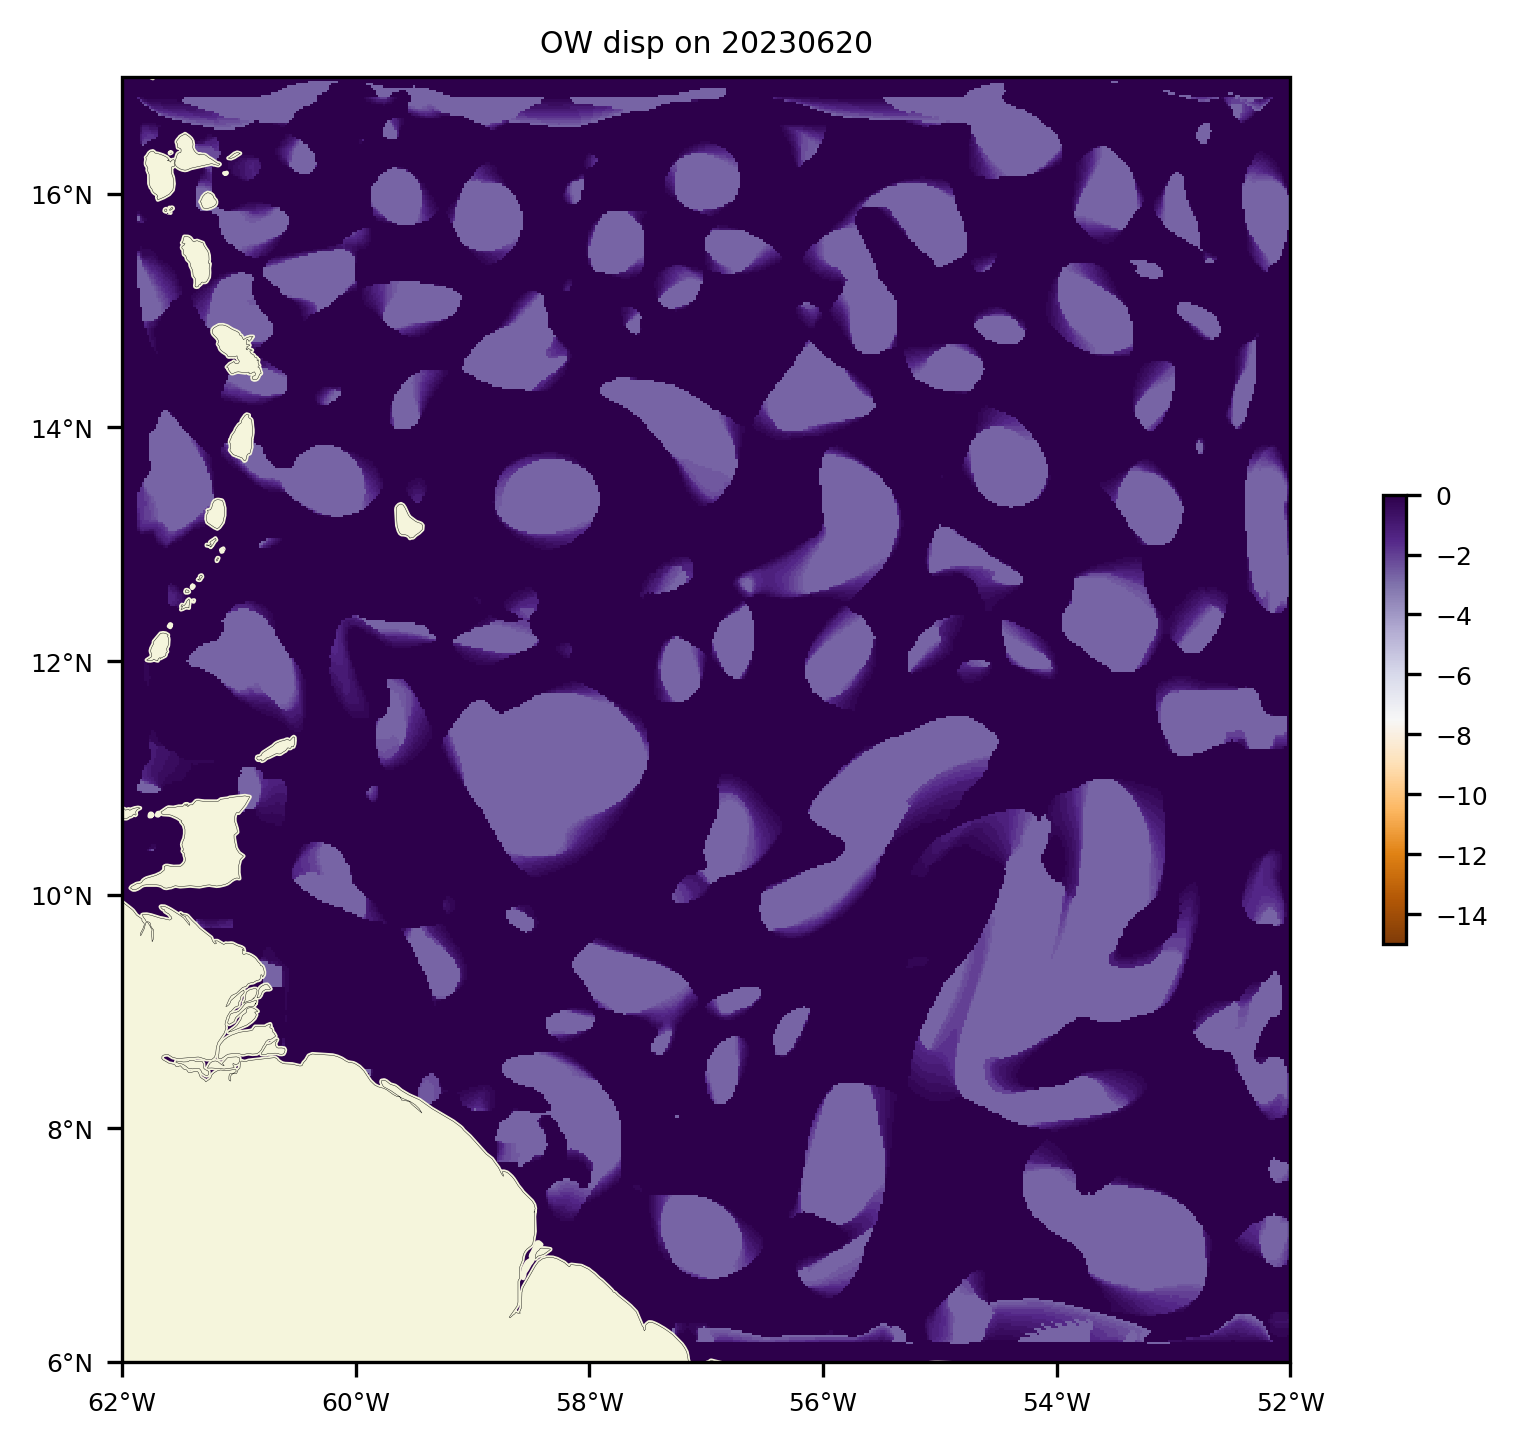

In [15]:
#######################################################################################
### 5. LAMTA LAGRANGIAN DIAGNOSTICS
#######################################################################################
if make_lagrangian_diags == True:
    dir_lamta = '/bettik/PROJECTS/pr-data-ocean/stellaa/lamtaLR'
    from tools.remapping import apply_lamta
    lamta_diags_results = apply_lamta(currdir, dir_lamta, today, bbox, numdays=3, bathylvl =-1500)

In [16]:
###########################################################################################################################################
### 6. UPLOAD MAPS
###########################################################################################################################################

# Here, choose the right function to send to the right place. 
if destination == 'ifremer':
    from tools.ftp_transfer import ftp_to_ifremer
    ftp_to_ifremer(today, currdir)